In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.pairs_selection import *
from util.backtest import *
from util.bands import *
plt.rcParams["font.family"] = "NanumGothic"
import warnings
warnings.filterwarnings(action='ignore')

import pickle
from pathlib import Path

In [2]:
# Data load
pairs_list = [('한화','한화우')
 #('LG전자', 'LG전자우'),
 #('LG화학', 'LG화학우'),
 #('삼성전자', '삼성전자우'),
 #('삼성화재', '삼성화재우'),
 #('현대차', '현대차우')
             ]

In [3]:
main_path = '/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv'
ohlcv_list=[]
price_pairs = []
stock_names = []
for pair in pairs_list:
    for j in pair:
        data = pd.read_csv(main_path + f'/{j}_ohlcv.csv', index_col=0, parse_dates=True)
        ohlcv_list.append(data)
        stock_names.append(j)
ohlcv_dict = dict(zip(stock_names, ohlcv_list))

In [4]:
futures = pd.read_csv('data/all_stocks_futures_prices_1min_20080623_20220929.csv', index_col=0, parse_dates=True)

In [5]:
common_prices = []
for pair in pairs_list:
    common_price = futures.resample('D').last()[pair[0]]
    common_prices.append(common_price)

In [6]:
common_futures_df = pd.concat(common_prices, axis=1).dropna()
#common_futures_df.loc[:'2018-4','삼성전자'] = common_futures_df.loc[:'2018-4','삼성전자']/50

In [7]:
trade_dates_all = []
used_pairs_list_all = []

common = pairs_list[0][0]
preferred = pairs_list[0][1]

common_price = common_futures_df[common].rename(common)  # 선물 데이터 사용
preferred_price = ohlcv_dict[preferred]['종가'].rename(preferred)
pairs_prices = pd.concat([common_price, preferred_price], axis=1)

# get spread
first = pairs_prices.dropna().iloc[:, 0]  # 보통주
second = pairs_prices.dropna().iloc[:, 1]  # 우선주
spread = get_log_spread(first, second)  # lny-lnx
#spread = second-first 

# make bands
window = 20
mult = 2
mult2 = 3
df_bb = bollinger_bands_double(spread, window, mult, mult2).dropna()

sp, lb, ub, ma = df_bb.price, df_bb.lb, df_bb.ub, df_bb.MA
lb2, ub2 = df_bb.lb2, df_bb.ub

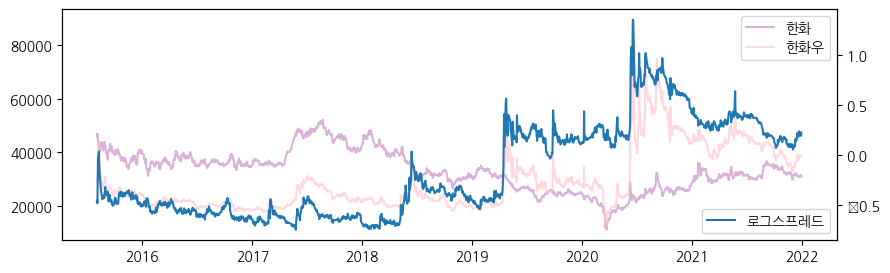

In [8]:
f, ax = plt.subplots(1, figsize=(10,3))
ax.plot(first['2009':'2021'], c='purple',  alpha=0.3)
ax.plot(second['2009':'2021'], c='pink', alpha=0.6)
plt.legend([common,preferred])
ax2 = ax.twinx()
ax2.plot(spread['2009':'2021'])
plt.legend(['로그스프레드'],loc='lower right')
plt.show()

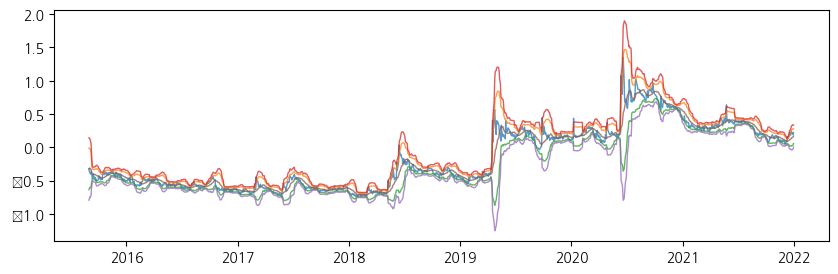

In [9]:
plt.figure(figsize=(10,3))
plt.plot(df_bb['2009':'2021'], alpha=0.75, linewidth=1)
plt.show()

In [10]:
trade_dates = get_trade_dates_bbd_long(sp, ub, lb, ub2, lb2)

#trade_dates = trade_dates[(trade_dates.entry >= start) & (trade_dates.entry < end)].reset_index(drop=True)

In [11]:
entry_spread = df_bb.price.loc[trade_dates.entry]
exit_spread = df_bb.price.loc[trade_dates.exit]

In [12]:
df_bb_samp = df_bb['2009-3':'2021']

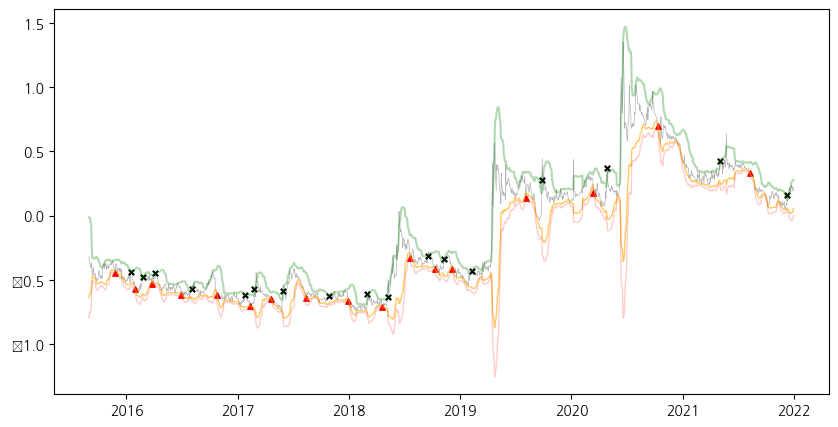

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df_bb_samp.price, c='black', alpha=0.3, linewidth=0.5)
plt.plot(df_bb_samp.lb, c='orange',alpha=0.6, linewidth=1)
plt.plot(df_bb_samp.lb2, c='red', alpha=0.2, linewidth=1)
plt.plot(df_bb_samp.ub, c='green', alpha=0.3)
plt.scatter(entry_spread['2009-3':'2021'].index, entry_spread['2009-3':'2021'], marker='^', c='red', s=15)
plt.scatter(exit_spread['2009-3':'2021'].index, exit_spread['2009-3':'2021'], marker='x',c='black', s=15)
plt.show()

# 실현손익

In [14]:
initial_invest = 100_000_000
c = 0.002  # 거래당

In [15]:
transactions_list = []

inventory_now = initial_invest
inventory_history = [inventory_now]

pnl1wc_list  = []
pnl2wc_list  = []

pnl1_list  = []
pnl2_list  = []

In [16]:
trade_dates_samp = trade_dates.loc[(trade_dates.entry>'2009-1-1') & (trade_dates.entry<'2022-1-1')]

In [17]:
for t in trade_dates_samp.index:  # t는 하나의 round-trip
    entry = pd.to_datetime(trade_dates_samp.entry[t])
    exit = pd.to_datetime(trade_dates_samp.exit[t])

    pos = trade_dates_samp.position[t]

    p1_in = first[entry]
    p2_in = second[entry]
    p1_out = first[exit]
    p2_out = second[exit]
    q1 = int(inventory_now / (2 * p1_in))
    q2 = int(inventory_now / (2 * p2_in))

    one_transaction = [[entry, -pos * q1, p1_in, common],
                       [entry, pos * q2, p2_in, preferred],
                       [exit, pos * q1, p1_out, common],
                       [exit, -pos * q2, p2_out, preferred]]
    one_transaction = pd.DataFrame(one_transaction, columns=['index', 'amount', 'price', 'symbol']).set_index(
        'index')

    pnl1_ = (-pos) * (q1 * p1_out - q1 * p1_in)
    cost1_ = c * (q1 * p1_out + q1 * p1_in)
    pnl2_ = pos * (q2 * p2_out - q2 * p2_in)
    cost2_ = c * (q2 * p2_out + q2 * p2_in)

    pnl1 = pnl1_ - cost1_
    pnl2 = pnl2_ - cost2_

    pnl1wc_list.append(pnl1_)
    pnl2wc_list.append(pnl2_)
    pnl1_list.append(pnl1)
    pnl2_list.append(pnl2)
    
    inventory_now += (pnl1 + pnl2)
    inventory_history.append(inventory_now)
    transactions_list.append(one_transaction)

transactions = pd.concat(transactions_list)

In [18]:
transactions_list = []

#inventory_now = initial_invest
inventory_now = 0
inventory_history = [inventory_now]

pnl1wc_list  = []
pnl2wc_list  = []

pnl1_list  = []
pnl2_list  = []

for t in trade_dates_samp.index:  # t는 하나의 round-trip
    entry = pd.to_datetime(trade_dates_samp.entry[t])
    exit = pd.to_datetime(trade_dates_samp.exit[t])

    pos = trade_dates_samp.position[t]

    p1_in = first[entry]
    p2_in = second[entry]
    p1_out = first[exit]
    p2_out = second[exit]
    q1 = int(initial_invest / (2 * p1_in))
    q2 = int(initial_invest / (2 * p2_in))

    one_transaction = [[entry, -pos * q1, p1_in, common],
                       [entry, pos * q2, p2_in, preferred],
                       [exit, pos * q1, p1_out, common],
                       [exit, -pos * q2, p2_out, preferred]]
    one_transaction = pd.DataFrame(one_transaction, columns=['index', 'amount', 'price', 'symbol']).set_index(
        'index')

    pnl1_ = (-pos) * (q1 * p1_out - q1 * p1_in)
    cost1_ = c * (q1 * p1_out + q1 * p1_in)
    pnl2_ = pos * (q2 * p2_out - q2 * p2_in)
    cost2_ = c * (q2 * p2_out + q2 * p2_in)

    pnl1 = pnl1_ - cost1_
    pnl2 = pnl2_ - cost2_

    pnl1wc_list.append(pnl1_)
    pnl2wc_list.append(pnl2_)
    pnl1_list.append(pnl1)
    pnl2_list.append(pnl2)
    
    inventory_now += (pnl1 + pnl2)
    inventory_history.append(inventory_now)
    transactions_list.append(one_transaction)

transactions = pd.concat(transactions_list)

In [19]:
t=1 #0부터 시작
transactions_list[t]

,amount,price,symbol
index,,,
2016-01-28,-1402,35650.0,한화
2016-01-28,2480,20159.0,한화우
2016-02-25,1402,34750.0,한화
2016-02-25,-2480,21496.0,한화우


In [20]:
print('보통주 손익: ', pnl1wc_list[t])
print('우선주 손익: ', pnl2wc_list[t])
print('페어 손익: ', pnl1wc_list[t] + pnl2wc_list[t])

보통주 손익:  1261800.0
우선주 손익:  3315760
페어 손익:  4577560.0


In [21]:
print('보통주 손익 (거래비용 차감): ', pnl1_list[t])
print('우선주 손익 (거래비용 차감): ', pnl2_list[t])
print('페어 손익 (거래비용 차감): ', pnl1_list[t] + pnl2_list[t])

보통주 손익 (거래비용 차감):  1064398.4
우선주 손익 (거래비용 차감):  3109151.2
페어 손익 (거래비용 차감):  4173549.6


In [22]:
print(f'매매{t+1} 전 Inventory: ', inventory_history[t])
print(f'매매{t+1} 후 Inventory: ', inventory_history[t+1])

매매2 전 Inventory:  135562.89600000065
매매2 후 Inventory:  4309112.496000001


In [23]:
ind_ = [list(trade_dates_samp.entry)[0]] + list(trade_dates_samp.exit) # 초기 투자일, 청산일들

In [24]:
inventory = pd.Series(inventory_history, index=pd.to_datetime(ind_))
inventory = inventory.resample('D').last().ffill()
inventory = inventory.to_frame()

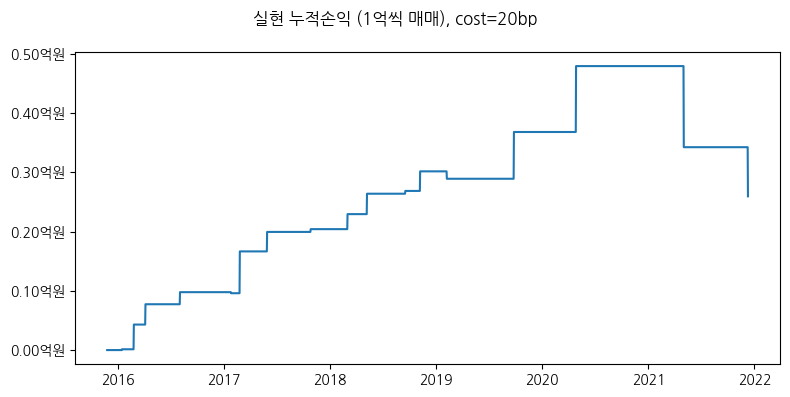

In [25]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(1, figsize=(8, 4))
f.suptitle('실현 누적손익 (1억씩 매매), cost=20bp')

i = inventory[0]
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda i,
                                pos: '{:,.2f}'.format(i / 100_000_000) + '억원'))
ax.plot(i)
f.tight_layout()

plt.show()

# 평가손익

In [26]:
trade_dates_samp = trade_dates.loc[(trade_dates.entry>'2009-1-1') & (trade_dates.entry<'2022-1-1')].reset_index(drop=True)

In [27]:
df_ = (second-first).rename('price').to_frame()['2009':].copy()
df_['position'] = 0
for i in range(len(trade_dates_samp)):
    df_.loc[trade_dates_samp.entry[i]:trade_dates_samp.exit[i], 'position'] = 1

In [28]:
second_amounts = abs(transactions[transactions.symbol==preferred].amount)
second_amounts = second_amounts[~second_amounts.index.duplicated(keep='last')]

first_amounts = abs(transactions[transactions.symbol==common].amount)
first_amounts = first_amounts[~first_amounts.index.duplicated(keep='last')]

In [29]:
second_df_ = pd.concat([second['2009':], second_amounts, df_['position']], axis=1).fillna(method='ffill')
first_df_ = pd.concat([first['2009':], first_amounts, df_['position']], axis=1).fillna(method='ffill')

price_ = second_df_.prod(axis=1) - first_df_.prod(axis=1)
평가손익 = price_.replace(0,np.nan).diff().cumsum().fillna(method='ffill')

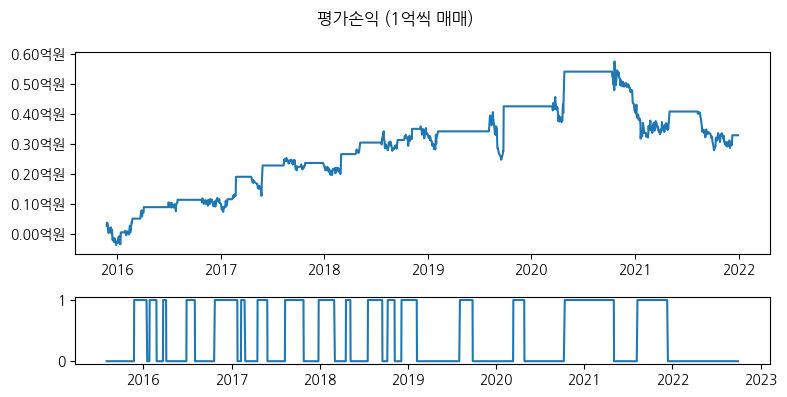

In [30]:
import matplotlib.ticker as ticker
f, ax = plt.subplots(2, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 1]})
f.suptitle('평가손익 (1억씩 매매)')

i = 평가손익[:'2021']
ax[0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda i,
                                pos: '{:,.2f}'.format(i / 100_000_000) + '억원'))
ax[0].plot(i)
f.tight_layout()
ax[1].plot(df_.position)

plt.show()

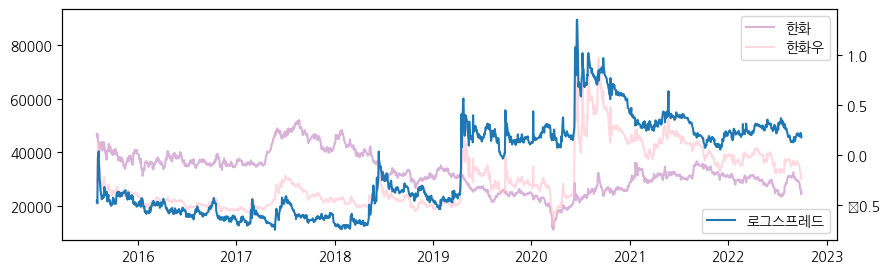

In [31]:
f, ax = plt.subplots(1, figsize=(10,3))
ax.plot(first['2009':], c='purple',  alpha=0.3)
ax.plot(second['2009':], c='pink', alpha=0.6)
plt.legend([common,preferred])
ax2 = ax.twinx()
ax2.plot(spread['2009':])
plt.legend(['로그스프레드'],loc='lower right')
plt.show()